In [8]:
!pip install seaborn
!pip install pyne2001
!pip install tqdm
!pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyne2001: filename=pyne2001-0.1.3-py3-none-any.whl size=93704 sha256=d3b597e59efa10576ee0a89b538f3237df6772b736f78a9c886bf669fdc3fa36
  Stored in directory: /tmp/pip-ephem-wheel-cache-072fs9_n/wheels/6b/a2/68/51e7e7b0a68b70e79a4f4479b9a81e95cc9a74daad2390aa53
Successfully built pyne2001
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 41.1 MB/s eta 0:00:00


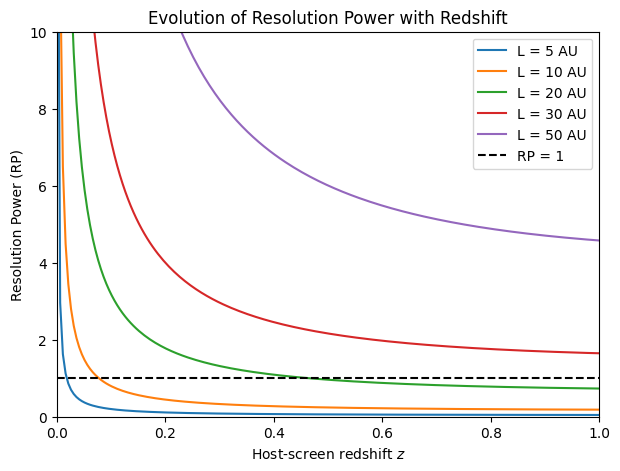

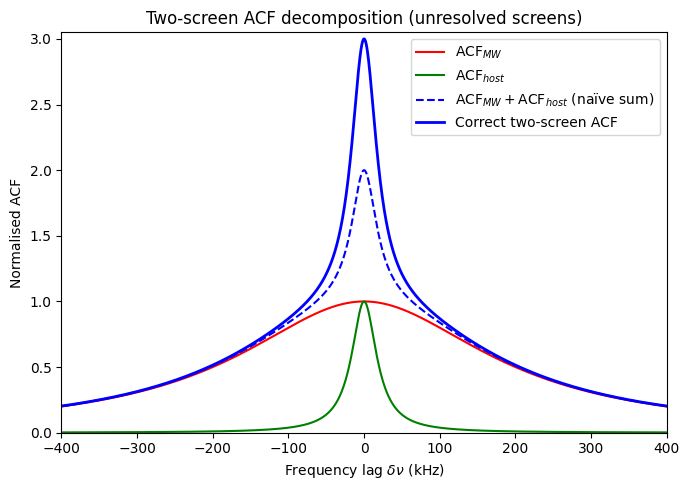

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------- Helper: D_A(z) -----------------------------
# Simple flat ΛCDM cosmology (Ω_m=0.3, Ω_Λ=0.7, H0=70 km/s/Mpc)
c_km_s = 299792.458
H0_km_s_Mpc = 70.0
Mpc_to_m = 3.085677581491367e22

def E_z(z):
    return np.sqrt(0.3 * (1 + z)**3 + 0.7)

def angular_diameter_distance(z):
    """Return D_A(0,z) in metres for flat ΛCDM."""
    z = np.asanyarray(z)
    # Numerically integrate comoving distance
    from numpy import trapz, linspace
    Dc = np.zeros_like(z, dtype=float)
    for i, zz in enumerate(z):
        zs = linspace(0, zz, 512)
        integrand = 1.0 / E_z(zs)
        Dc[i] = trapz(integrand, zs)
    Dc *= c_km_s / H0_km_s_Mpc * Mpc_to_m  # comoving metres
    return Dc / (1 + z)                    # angular‑diameter distance

# ----------------------------- Figure 1: RP(z) -----------------------------
L_values_AU = np.array([5, 10, 20, 30, 50])        # AU
AU_to_m = 1.495978707e11
L_values_m = L_values_AU * AU_to_m                 # metres

nu0_Hz = 1.25e9                                    # observing frequency
lam_m = 299792458.0 / nu0_Hz                       # wavelength in metres

z_grid = np.linspace(0.001, 3.0, 600)

fig1, ax1 = plt.subplots(figsize=(7, 5))
D_grid_m = angular_diameter_distance(z_grid)

for Lm in L_values_m:
    RP = (Lm * Lm) / (lam_m * D_grid_m)
    ax1.plot(z_grid, RP, label=f"L = {Lm / AU_to_m:.0f} AU")

ax1.axhline(1.0, linestyle="--", color="k", label="RP = 1")
ax1.set_xlabel("Host‑screen redshift $z$")
ax1.set_ylabel("Resolution Power (RP)")
#ax1.set_yscale("log")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 10)
ax1.legend()
ax1.set_title("Evolution of Resolution Power with Redshift")

# ------------------------- Figure 2: ACF components -------------------------
vs_mw   = 200.0   # kHz
vs_host =  20.0   # kHz

lag_khz = np.linspace(-400, 400, 1601)
dv = np.abs(lag_khz)

lorentz = lambda dv, vs: 1 / (1 + (dv / vs)**2)

ACF_MW   = lorentz(dv, vs_mw)
ACF_host = lorentz(dv, vs_host)
ACF_full = ACF_MW * ACF_host + ACF_MW + ACF_host
ACF_sum  = ACF_MW + ACF_host

fig2, ax2 = plt.subplots(figsize=(7, 5))
ax2.plot(lag_khz, ACF_MW,   color="red",   label=r"$\mathrm{ACF}_{MW}$")
ax2.plot(lag_khz, ACF_host, color="green", label=r"$\mathrm{ACF}_{host}$")
ax2.plot(lag_khz, ACF_sum,  color="blue",  linestyle="--",
         label=r"$\mathrm{ACF}_{MW}+\mathrm{ACF}_{host}$ (naïve sum)")
ax2.plot(lag_khz, ACF_full, color="blue",  linewidth=2,
         label="Correct two‑screen ACF")

ax2.set_xlabel(r"Frequency lag $\delta \nu$ (kHz)")
ax2.set_ylabel("Normalised ACF")
ax2.set_title("Two‑screen ACF decomposition (unresolved screens)")
ax2.legend(loc="upper right")
ax2.set_xlim(-400, 400)
ax2.set_ylim(0, 3.05)

plt.tight_layout()
plt.show()


Numba detected. Using JIT-accelerated version.
RP = 0.0031891405109402368
ν_s (MW) = 1050.5 kHz, ν_s (host) = 1011.9 kHz


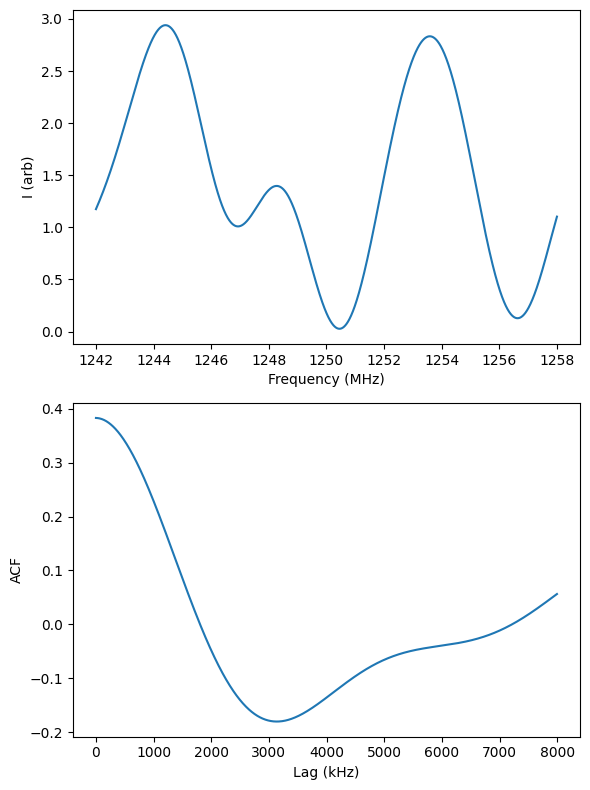

In [2]:
import os
import sys
sys.path.append("/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/scattering/simulation")

from frb_scintillator_v8 import u, ScreenCfg, SimCfg, FRBScintillator

import numpy as np
import matplotlib.pyplot as plt

cfg = SimCfg(
    z_host=0.3,
    nchan=2048,
    mw=ScreenCfg(axial_ratio=2.0, pa=30*u.deg, profile="powerlaw", alpha=4),
    host=ScreenCfg(profile="powerlaw", alpha=4),
    intrinsic_pulse="delta",
    noise_snr=10,
    pulse_width=10*u.us
)
sim = FRBScintillator(cfg)
spec = sim.simulate_time_integrated_spectrum()
corr, lags = sim.acf(spec)
w1, w2 = sim.fit_acf(corr, lags)

print("RP =", sim.resolution_power())
print("ν_s (MW) = %.1f kHz, ν_s (host) = %.1f kHz" % (w1/1e3, w2/1e3))

fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(sim.freqs / 1e6, spec)
ax[0].set_xlabel("Frequency (MHz)")
ax[0].set_ylabel("I (arb)")

ax[1].plot(lags * sim.dnu / 1e3, corr)
ax[1].set_xlabel("Lag (kHz)")
ax[1].set_ylabel("ACF")
plt.tight_layout()
plt.show()

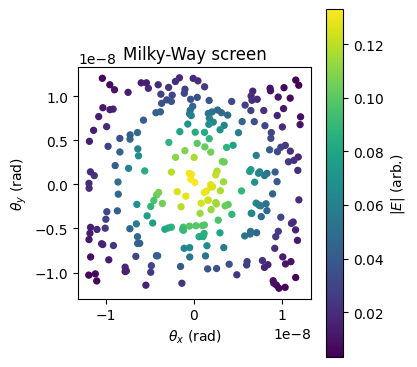

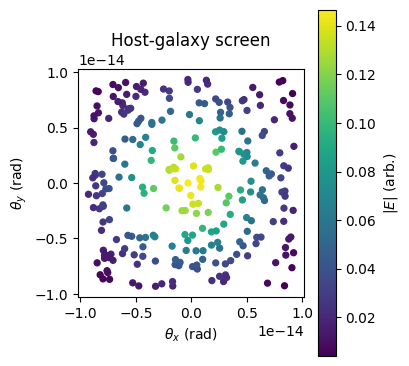

In [3]:
# ------------------------------------------------------------------
# 1.  Instantiate a simulator with any screen parameters you like
# ------------------------------------------------------------------
cfg = SimCfg(
    mw   = ScreenCfg(N=256, L=5*u.AU,  profile="gaussian"),
    host = ScreenCfg(N=256, L=5*u.AU,  profile="gaussian"),
)
sim = FRBScintillator(cfg)

# ------------------------------------------------------------------
# 2.  Grab positions and amplitudes from each screen
# ------------------------------------------------------------------
def scatter_screen(screen, title):
    tx, ty   = screen.theta.T                 # radians
    amp      = np.abs(screen.field)           # Gaussian envelope already included
    plt.figure(figsize=(4.2,4))
    plt.scatter(tx, ty, c=amp, cmap="viridis", s=18)
    plt.colorbar(label=r"$|E|$ (arb.)")
    plt.xlabel(r"$\theta_x$ (rad)"); plt.ylabel(r"$\theta_y$ (rad)")
    plt.gca().set_aspect("equal")
    plt.title(title)
    plt.tight_layout()

scatter_screen(sim.mw_screen,   "Milky-Way screen")
scatter_screen(sim.host_screen, "Host-galaxy screen")
plt.show()


/tmp/ipykernel_1275/3968471020.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


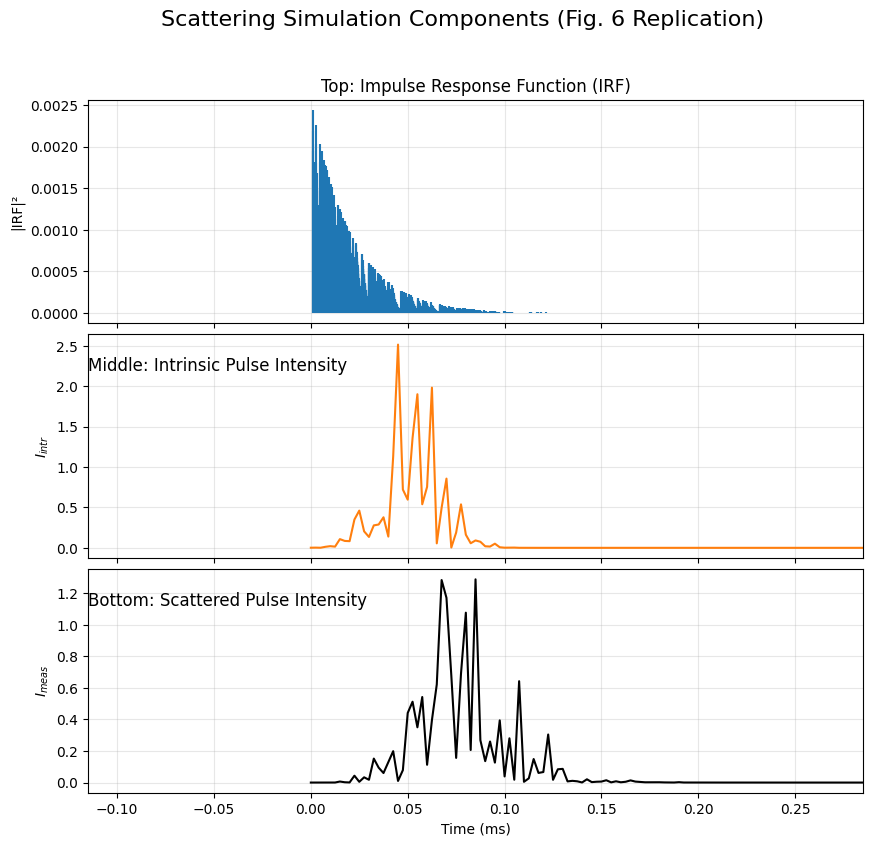

In [7]:
import os
import sys
sys.path.append("/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/scattering/simulation")

import numpy as np
import matplotlib.pyplot as plt

from frb_scintillator_v8 import u, SimCfg, ScreenCfg, FRBScintillator # Assuming saved as file

cfg = SimCfg(
    nu0=800 * u.MHz,
    D_mw=1.0 * u.kpc,
    z_host=0.1,
    D_host_src=10.0 * u.kpc,
    mw=ScreenCfg(N=100, L=5 * u.AU, rng_seed=11),
    host=ScreenCfg(N=100, L=50 * u.AU, rng_seed=13),
    intrinsic_pulse="gauss",
    pulse_width=0.05 * u.ms,
    noise_snr = 100
)
sim = FRBScintillator(cfg)

# --- Generate Data ---
irf_delays, irf_intensities = sim.get_irf_spikes()
duration = (np.max(irf_delays) + 5 * cfg.pulse_width.to(u.s).value) * u.s
time_res = cfg.pulse_width / 20

scattered_pulse, intrinsic_pulse, time_axis = sim.simulate_scattered_time_series(
    time_res=time_res, duration=duration
)

# --- Plotting ---
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True,
                         gridspec_kw={'hspace': 0.05})
fig.suptitle("Scattering Simulation Components (Fig. 6 Replication)", fontsize=16)

# Top Panel: Impulse Response Function
axes[0].stem(irf_delays * 1e3, irf_intensities, linefmt='C0-', markerfmt=' ', basefmt=" ")
axes[0].set_ylabel("|IRF|²")
axes[0].set_title("Top: Impulse Response Function (IRF)")

# Middle Panel: Intrinsic Pulse
axes[1].plot(time_axis * 1e3, intrinsic_pulse, color='C1')
axes[1].set_ylabel("$I_{intr}$")
axes[1].set_title("Middle: Intrinsic Pulse Intensity", loc='left', y=0.8)

# Bottom Panel: Scattered Pulse
axes[2].plot(time_axis * 1e3, scattered_pulse, color='k')
axes[2].set_ylabel("$I_{meas}$")
axes[2].set_xlabel("Time (ms)")
axes[2].set_title("Bottom: Scattered Pulse Intensity", loc='left', y=0.8)

# --- Centering and setting x-limits ---
# Find the time of the peak of the scattered pulse
peak_time_ms = time_axis[np.argmax(scattered_pulse)] * 1e3

# Define a window around the peak for plotting
window_width_ms = 8 * cfg.pulse_width.to(u.ms).value

# Set the x-limits for all shared axes
start_time = peak_time_ms - window_width_ms / 2
end_time = peak_time_ms + window_width_ms / 2
axes[0].set_xlim(start_time, end_time)

for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelbottom=False)
axes[2].tick_params(labelbottom=True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


--- Unresolved Regime Validation ---
Expected theoretical peak ACF value: 3.0 (since m_total^2 = (sqrt(3))^2)
Simulated peak ACF value: 3.1549
✅ SUCCESS: The result is consistent with the theoretical prediction.
------------------------------------



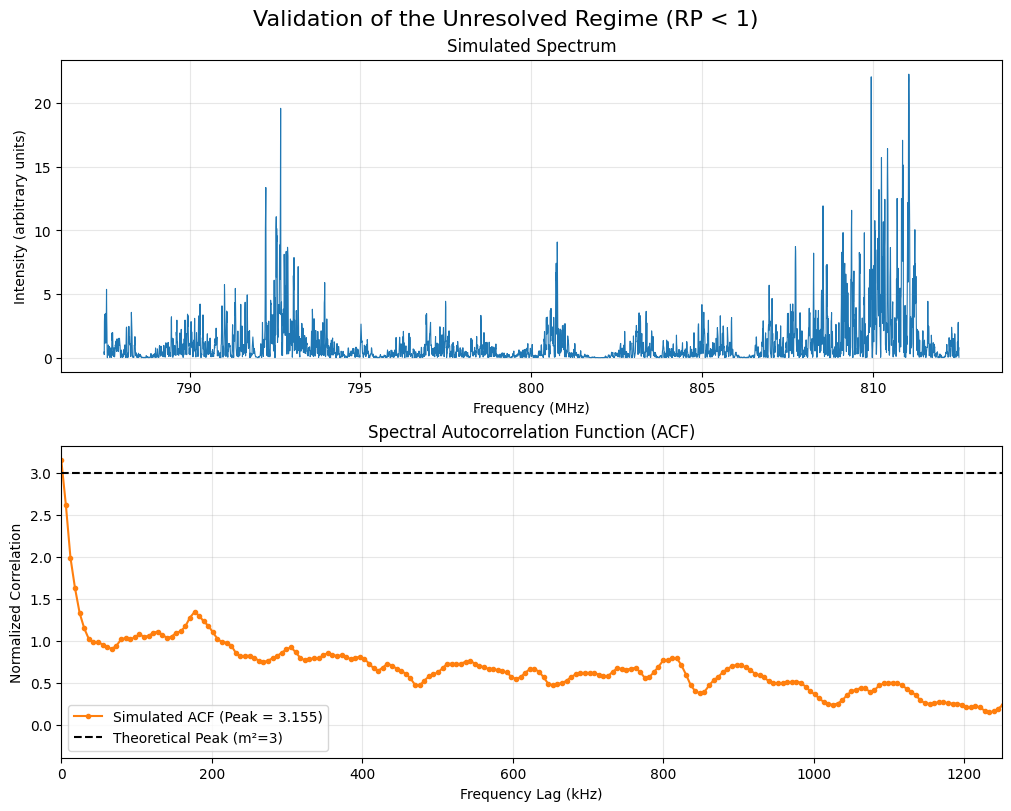

In [13]:
import os
import sys
sys.path.append("/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/scattering/simulation")

import numpy as np
import matplotlib.pyplot as plt

from frb_scintillator_v8 import u, SimCfg, ScreenCfg, FRBScintillator # Assuming saved as file

# --- Configuration ---
# Parameters are set to match the "unresolved" case from Table B.1
# in Pradeep et al. (2025), which should yield RP ≈ 0.2.
cfg_unresolved = SimCfg(
    nu0=800 * u.MHz,
    bw=25.0 * u.MHz,
    nchan=4096,  # Increased for better ACF statistics
    z_host=0.192,
    D_mw=2.3 * u.kpc,
    D_host_src=2.0 * u.kpc,
    mw=ScreenCfg(
        N=200,  # Number of images
        L=3.5 * u.AU,
        rng_seed=1234
    ),
    host=ScreenCfg(
        N=200, # Number of images
        L=20.0 * u.AU,
        rng_seed=5678
    ),
    intrinsic_pulse="delta", # Use delta function to avoid self-noise
    noise_snr=None # No noise for pure theoretical test
)
# --- Simulation ---
sim = FRBScintillator(cfg_unresolved)
spectrum = sim.simulate_time_integrated_spectrum()
# --- Analysis ---
corr, lags = sim.acf(spectrum)
peak_acf_value = corr[0]
# --- Report Results ---
print("\n--- Unresolved Regime Validation ---")
print(f"Expected theoretical peak ACF value: 3.0 (since m_total^2 = (sqrt(3))^2)")
print(f"Simulated peak ACF value: {peak_acf_value:.4f}")
# Check if the result is close to the theory
if np.isclose(peak_acf_value, 3.0, atol=0.2):
    print("✅ SUCCESS: The result is consistent with the theoretical prediction.")
else:
    print("❌ FAILED: The result deviates significantly from the theory.")
print("------------------------------------\n")
# --- Visualization ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)
fig.suptitle("Validation of the Unresolved Regime (RP < 1)", fontsize=16)
# Plot Spectrum
ax1.plot(sim.freqs / 1e6, spectrum, color='C0', lw=0.8)
ax1.set_title("Simulated Spectrum")
ax1.set_xlabel("Frequency (MHz)")
ax1.set_ylabel("Intensity (arbitrary units)")
ax1.grid(True, alpha=0.3)
# Plot ACF
lags_khz = lags * sim.dnu / 1e3
ax2.plot(lags_khz, corr, '.-', color='C1', label=f'Simulated ACF (Peak = {peak_acf_value:.3f})')
ax2.axhline(3.0, color='k', ls='--', label='Theoretical Peak (m²=3)')
ax2.set_title("Spectral Autocorrelation Function (ACF)")
ax2.set_xlabel("Frequency Lag (kHz)")
ax2.set_ylabel("Normalized Correlation")
ax2.set_xlim(0, lags_khz[-1] / 10) # Zoom in on the central part
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.show()

Estimated max scattering delay: 11.34 ms
Total simulation duration: 17.51 ms
Synthesising dynamic spectrum...
Bandwidth is 25000000.0 Hz, so dt is set to 1/25000000.0 = 4e-08 s to satisfy Nyquist
Synthesis complete.


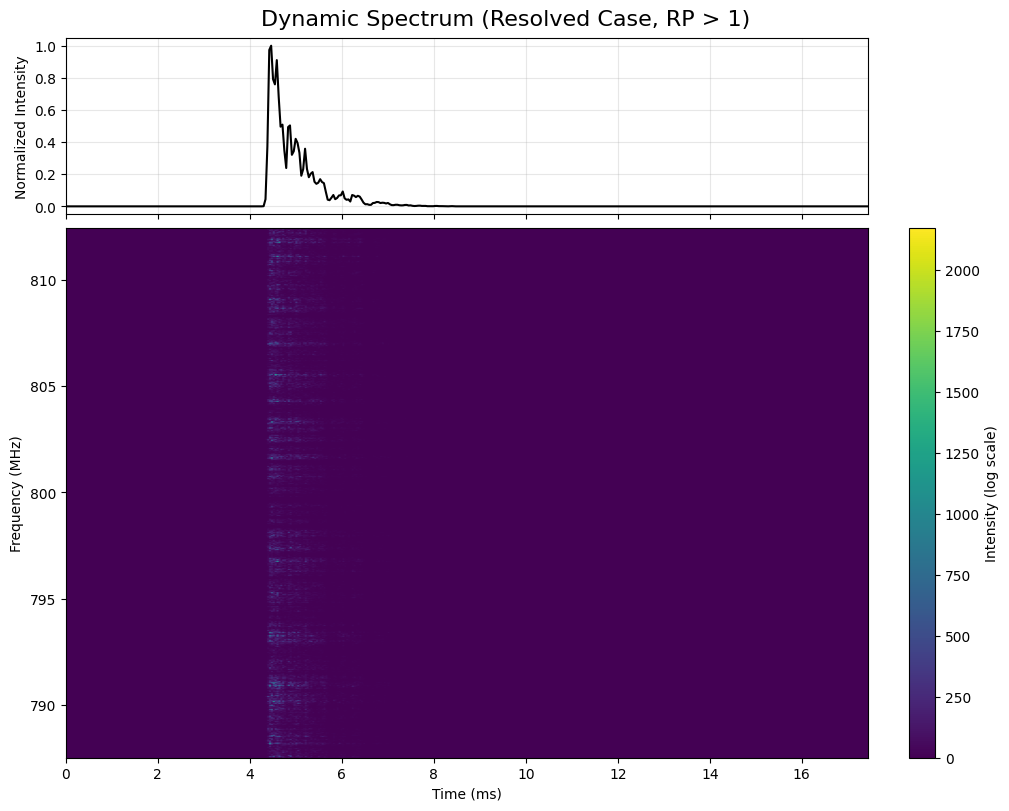

In [2]:
import os
import sys
sys.path.append("/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/scattering/simulation")

import numpy as np
import matplotlib.pyplot as plt

from frb_scintillator_v8 import u, SimCfg, ScreenCfg, FRBScintillator # Assuming saved as file

# Configuration based on the "completely resolved" case from Table B.1
cfg_resolved = SimCfg(
    nu0=800 * u.MHz,
    bw=25 * u.MHz,
    nchan=1024,
    D_mw=1.29 * u.kpc,
    z_host=0.0337,
    D_host_src=3.0 * u.kpc,
    mw=ScreenCfg(N=200, L=4.12 * u.AU, rng_seed=2025),
    host=ScreenCfg(N=200, L=165 * u.AU, rng_seed=2026),
    intrinsic_pulse="gauss",
    pulse_width=0.1 * u.ms,
)

sim = FRBScintillator(cfg_resolved)

# Define simulation time parameters
# The duration needs to be long enough to capture the full scattering tail
max_delay_est = sim.deff_host_m * (cfg_resolved.host.L.to(u.m).value / sim.D_host_m)**2 / (2*3e8)
# Ensure duration is significantly longer than the scattering tail
sim_duration = (max_delay_est * 1.5 + 5 * cfg_resolved.pulse_width.to(u.s).value) * u.s

print(f"Estimated max scattering delay: {max_delay_est*1e3:.2f} ms")
print(f"Total simulation duration: {sim_duration.to(u.ms):.2f}")

print("Synthesising dynamic spectrum...")
I_t_nu, time_axis, freq_axis = sim.synthesise_dynamic_spectrum(
    duration=sim_duration
)

if I_t_nu.size == 0:
    print("Failed to generate dynamic spectrum. Exiting.")

print("Synthesis complete.")

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 8), constrained_layout=True, 
    gridspec_kw={'height_ratios': [1, 3]}
)
fig.suptitle("Dynamic Spectrum (Resolved Case, RP > 1)", fontsize=16)

# Top panel: Time series (pulse profile)
pulse_profile = I_t_nu.mean(axis=1)
ax1.plot(time_axis * 1e3, pulse_profile / pulse_profile.max(), color='k')
ax1.set_ylabel("Normalized Intensity")
ax1.set_xlim(0, time_axis.max() * 1e3)
ax1.set_xticklabels([])
ax1.grid(True, alpha=0.3)

# Bottom panel: Dynamic spectrum
vmin = np.percentile(I_t_nu[I_t_nu > 0], 5) if I_t_nu[I_t_nu > 0].size > 0 else 1e-9
vmax = np.percentile(I_t_nu, 99.5) if I_t_nu.size > 0 else 1

im = ax2.imshow(
    I_t_nu.T,
    aspect='auto',
    origin='lower',
    extent=[
        time_axis.min() * 1e3, time_axis.max() * 1e3,
        freq_axis.min() / 1e6, freq_axis.max() / 1e6
    ],
    cmap='viridis',
    #norm=plt.cm.colors.LogNorm(vmin=vmin, vmax=vmax) if vmax > vmin else None
)

ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Frequency (MHz)")
fig.colorbar(im, ax=ax2, label="Intensity (log scale)")

plt.show()

Numba detected. Using JIT-accelerated version.
Synthesising dynamic spectrum...
Bandwidth is 25000000.0 Hz, so dt is set to 1/25000000.0 = 4e-08 s to satisfy Nyquist


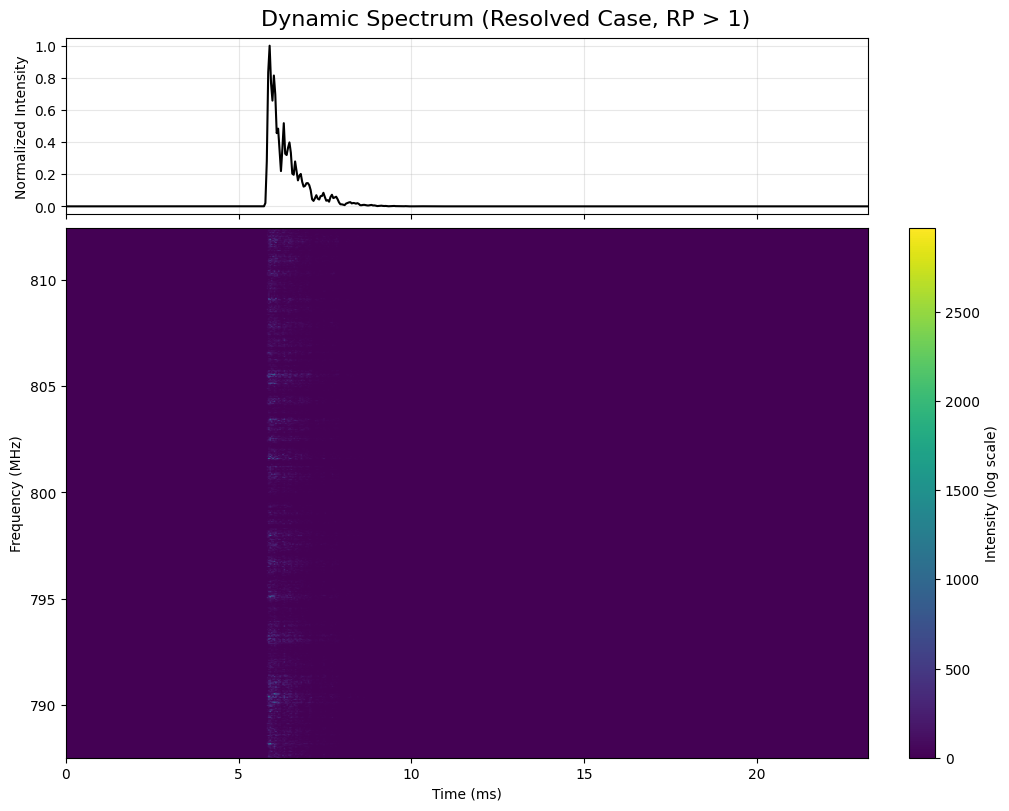

Synthesis complete.
Analyzing scintillation evolution across the pulse...


Analyzing time slices: 100%|██████████| 142/142 [00:00<00:00, 1266.51it/s]

Modulation Indices: [1.73176568 1.73064868 1.72289607 1.68955522 1.5755488  1.18493227
 0.74643614]


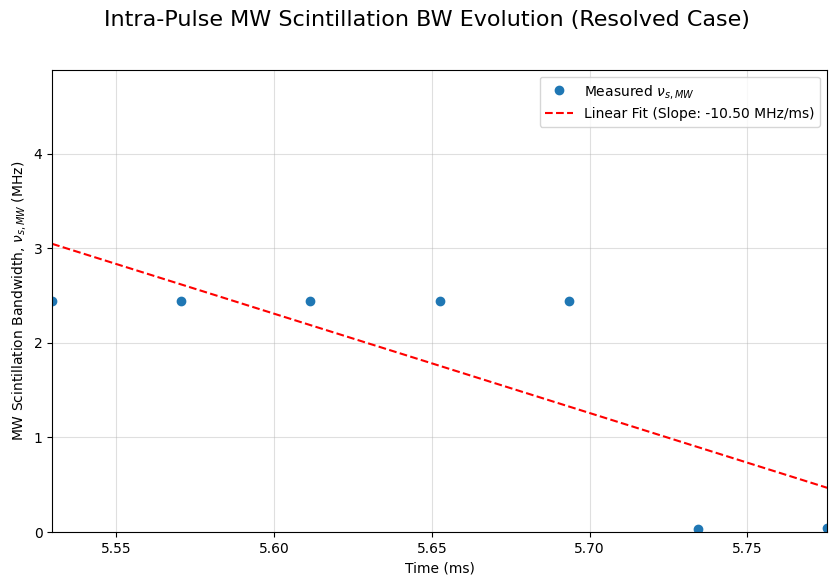

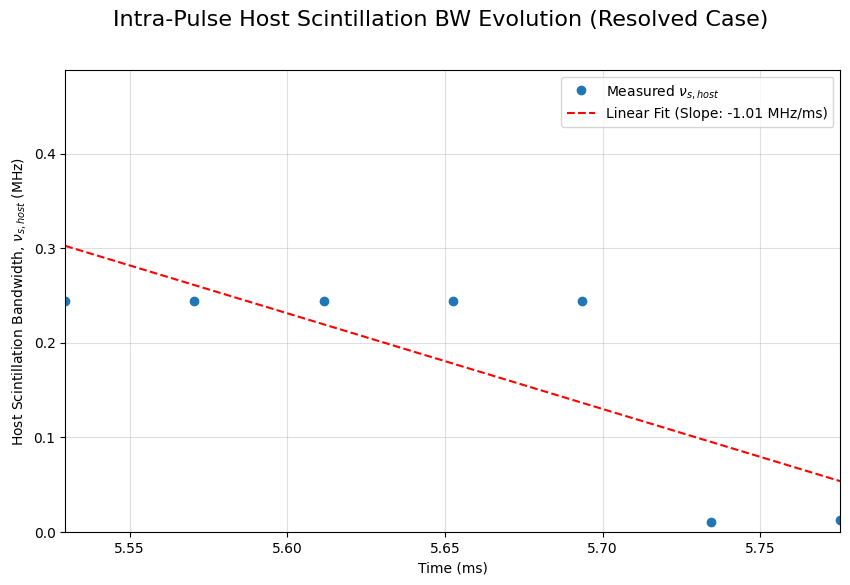

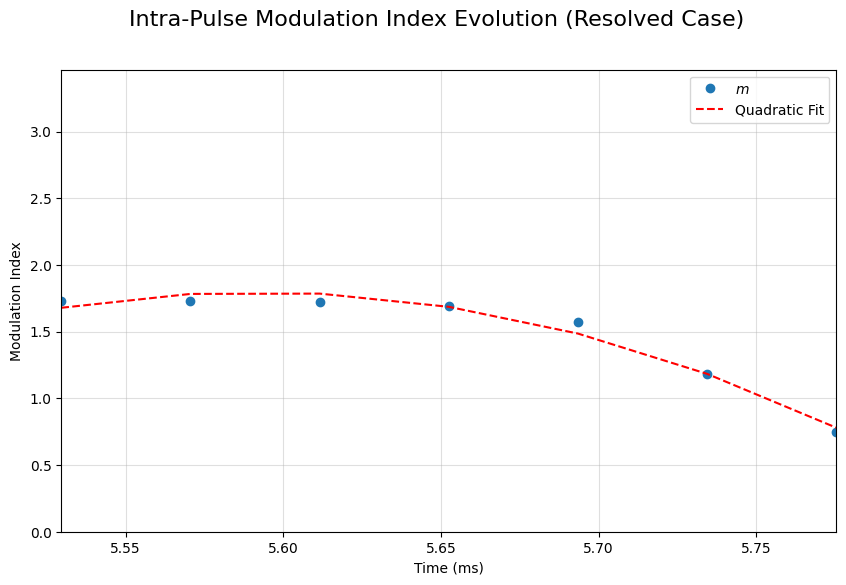

In [1]:
import os
import sys
sys.path.append("/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/scattering/simulation")

import numpy as np
import matplotlib.pyplot as plt

from frb_scintillator_v8 import u, SimCfg, ScreenCfg, FRBScintillator # Assuming saved as file

# Configuration based on the "completely resolved" case from Table B.1
cfg_resolved = SimCfg(
    nu0=800 * u.MHz,
    bw=25 * u.MHz,
    nchan=1024,
    D_mw=1.29 * u.kpc,
    z_host=0.0337,
    D_host_src=3.0 * u.kpc,
    mw=ScreenCfg(N=200, L=4.12 * u.AU, rng_seed=2025),
    host=ScreenCfg(N=200, L=165 * u.AU, rng_seed=2026),
    intrinsic_pulse="gauss",
    pulse_width=0.1 * u.ms,
)

sim = FRBScintillator(cfg_resolved)

max_delay_est = sim.deff_host_m * (cfg_resolved.host.L.to(u.m).value / sim.D_host_m)**2 / (2*3e8)
sim_duration = (max_delay_est * 2.0 + 6 * cfg_resolved.pulse_width.to(u.s).value) * u.s

print("Synthesising dynamic spectrum...")
I_t_nu, time_axis, freq_axis = sim.synthesise_dynamic_spectrum(duration=sim_duration)

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 8), constrained_layout=True, 
    gridspec_kw={'height_ratios': [1, 3]}
)
fig.suptitle("Dynamic Spectrum (Resolved Case, RP > 1)", fontsize=16)

# Top panel: Time series (pulse profile)
pulse_profile = I_t_nu.mean(axis=1)
ax1.plot(time_axis * 1e3, pulse_profile / pulse_profile.max(), color='k')
ax1.set_ylabel("Normalized Intensity")
ax1.set_xlim(0, time_axis.max() * 1e3)
ax1.set_xticklabels([])
ax1.grid(True, alpha=0.3)

# Bottom panel: Dynamic spectrum
vmin = np.percentile(I_t_nu[I_t_nu > 0], 5) if I_t_nu[I_t_nu > 0].size > 0 else 1e-9
vmax = np.percentile(I_t_nu, 99.5) if I_t_nu.size > 0 else 1

im = ax2.imshow(
    I_t_nu.T,
    aspect='auto',
    origin='lower',
    extent=[
        time_axis.min() * 1e3, time_axis.max() * 1e3,
        freq_axis.min() / 1e6, freq_axis.max() / 1e6
    ],
    cmap='viridis',
    #norm=plt.cm.colors.LogNorm(vmin=vmin, vmax=vmax) if vmax > vmin else None
)

ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Frequency (MHz)")
fig.colorbar(im, ax=ax2, label="Intensity (log scale)")

plt.show()

if I_t_nu.size == 0:
    print('I_t_nu is empty!')

print("Synthesis complete.")

# --- NEW: Analyze the dynamic spectrum ---
analysis_results = sim.analyze_intra_pulse_scintillation(I_t_nu)

valid_times = time_axis[analysis_results["valid_indices"]]
nu_s_mw_evol = analysis_results["nu_s_mw"]
nu_s_host_evol = analysis_results["nu_s_host"]
mod_idx_evol = analysis_results["m_total"]
print(f"Modulation Indices: {mod_idx_evol}")

# --- Plotting ---
fig = plt.figure(figsize=(10, 6))
plt.suptitle("Intra-Pulse MW Scintillation BW Evolution (Resolved Case)", fontsize=16)

plt.plot(valid_times * 1e3, nu_s_mw_evol / 1e6, 'o', label='Measured $\\nu_{s,MW}$')

# Perform a linear fit, as shown in the paper's Figure 10
if len(valid_times) > 1:
    p = np.polyfit(valid_times, nu_s_mw_evol, 1)
    plt.plot(valid_times * 1e3, (p[0] * valid_times + p[1]) / 1e6, 'r--', label=f'Linear Fit (Slope: {p[0]/1e9:.2f} MHz/ms)')

plt.xlabel("Time (ms)")
plt.ylabel("MW Scintillation Bandwidth, $\\nu_{s,MW}$ (MHz)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.ylim(0, 2*np.nanmax(nu_s_mw_evol) / 1e6) #plt.ylim(bottom=0)
plt.xlim(valid_times[0]*1e3, valid_times[-1]*1e3) #plt.xlim(left=0)

plt.show()

fig = plt.figure(figsize=(10, 6))
plt.suptitle("Intra-Pulse Host Scintillation BW Evolution (Resolved Case)", fontsize=16)

plt.plot(valid_times * 1e3, nu_s_host_evol / 1e6, 'o', label='Measured $\\nu_{s,host}$')

# Perform a linear fit, as shown in the paper's Figure 10
if len(valid_times) > 1:
    p = np.polyfit(valid_times, nu_s_host_evol, 1)
    plt.plot(valid_times * 1e3, (p[0] * valid_times + p[1]) / 1e6, 'r--', label=f'Linear Fit (Slope: {p[0]/1e9:.2f} MHz/ms)')

plt.xlabel("Time (ms)")
plt.ylabel("Host Scintillation Bandwidth, $\\nu_{s,host}$ (MHz)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.ylim(0, 2*np.nanmax(nu_s_host_evol) / 1e6) #plt.ylim(bottom=0)
plt.xlim(valid_times[0]*1e3, valid_times[-1]*1e3) #plt.xlim(left=0)

plt.show()

fig = plt.figure(figsize=(10, 6))
plt.suptitle("Intra-Pulse Modulation Index Evolution (Resolved Case)", fontsize=16)

plt.plot(valid_times * 1e3, mod_idx_evol, 'o', label='$m$')

# Perform a linear fit, as shown in the paper's Figure 10
if len(valid_times) > 1:
    p = np.polyfit(valid_times, mod_idx_evol, 2) # Quadratic fit
    mod_idx_curve = p[0] * valid_times**2 + p[1] * valid_times + p[2]
    plt.plot(valid_times * 1e3, mod_idx_curve, 'r--', label=f'Quadratic Fit') # (Slope: {p[0]/1e9:.2f} MHz/ms)')

plt.xlabel("Time (ms)")
plt.ylabel("Modulation Index")
plt.legend()
plt.grid(True, alpha=0.4)
plt.ylim(0, 2*np.nanmax(mod_idx_evol)) #plt.ylim(bottom=0)
plt.xlim(valid_times[0]*1e3, valid_times[-1]*1e3) #plt.xlim(left=0)

plt.show()


In [2]:
# ------------------------------------------------------------------
# Code to generate Figure 14 in Pradeep et al. 2025
# ------------------------------------------------------------------

#import os
#import sys
#sys.path.append("/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/scattering/simulation")
#
#import matplotlib.pyplot as plt
#import seaborn as sns
#from monte_carlo import run_monte_carlo_parallel # Assumes file saving
#
#n_trials = 500
#
#df = run_monte_carlo_parallel(n_trials=n_trials) #, nu0=0.6, bw=0.1, nchan=1024)
#
#if df.empty:
#    print("No valid trials completed. Cannot generate plot.")
#
#df['ratio_main'] = df['est_main_kpc'] / df['injected_D_h_src_kpc']
#df['ratio_ocker'] = df['est_ocker_kpc'] / df['injected_D_h_src_kpc']
#df['ratio_sammons'] = df['est_sammons_kpc'] / df['injected_D_h_src_kpc']
#df['ratio_pradeep'] = df['est_pradeep_kpc'] / df['injected_D_h_src_kpc']
#
#plt.style.use('seaborn-v0_8-whitegrid')
#fig, ax = plt.subplots(figsize=(12, 8))
#
#bins = np.linspace(0, 15, 31)
#df['rp_bin'] = pd.cut(df['rp'], bins=bins, labels= (bins[:-1] + bins[1:]) / 2)
#
#for key, color, label in [
#    ('ratio_pradeep', 'C0', 'This Work (Pradeep et al. 2025)'),
#    ('ratio_sammons', 'C1', 'Sammons et al. 2023'),
#    ('ratio_ocker', 'C2', 'Ocker et al. 2022'),
#    ('ratio_main', 'C3', 'Main et al. 2022 (approx.)'),
#]:
#    # Drop NaN bins that may result from low trial counts
#    grouped = df.groupby('rp_bin')[key].median().dropna()
#    q16 = df.groupby('rp_bin')[key].quantile(0.16).dropna()
#    q84 = df.groupby('rp_bin')[key].quantile(0.84).dropna()
#
#    # Ensure indices align after dropping NaNs
#    common_idx = grouped.index.intersection(q16.index).intersection(q84.index)
#
#    ax.plot(common_idx, grouped[common_idx], color=color, label=label, lw=2)
#    ax.fill_between(common_idx, q16[common_idx], q84[common_idx], color=color, alpha=0.3, linewidth=0)
#
#ax.set_xlabel("Resolution Power (RP)", fontsize=14)
#ax.set_ylabel("Estimated / Injected Host Distance", fontsize=14)
#ax.set_title("Comparison of Host Screen Distance Estimators", fontsize=16)
#ax.legend(fontsize=12)
#ax.set_ylim(0, 8)
#ax.set_xlim(0, 15)
#
#plt.show()

Simulating parallel 1D screens...
Simulating perpendicular 1D screens...
Simulations complete. Plotting results...


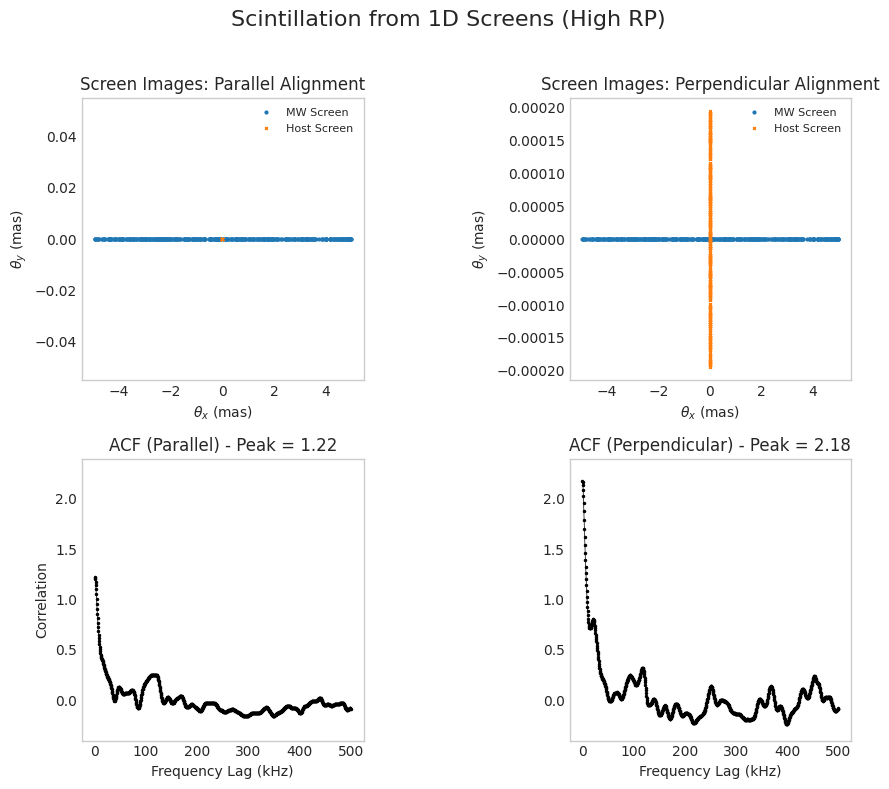

In [5]:
import os
import sys
sys.path.append("/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/scattering/simulation")

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except:
    os.system('pip install seaborn')

from frb_scintillator_v8 import u, SimCfg, ScreenCfg, FRBScintillator

"""
Generates and plots a comparison between parallel and perpendicular
1D screens, replicating the result from Figure 15.
"""

# --- Base configuration for a high-RP system ---
base_cfg_dict = {
    "nu0": 800 * u.MHz, "bw": 1.0 * u.MHz, "nchan": 2048,
    "D_mw": 1.0 * u.kpc, "z_host": 0.03, "D_host_src": 5.0 * u.kpc,
}
# These screen parameters result in a high RP (~12.4 in the paper)
mw_screen_cfg = ScreenCfg(N=400, L=10 * u.AU, geometry="1D", rng_seed=2025)
host_screen_cfg = ScreenCfg(N=400, L=50 * u.AU, geometry="1D", rng_seed=2026)

# --- Case 1: Parallel Screens ---
print("Simulating parallel 1D screens...")
cfg_parallel = SimCfg(
    **base_cfg_dict,
    mw=mw_screen_cfg,
    host=host_screen_cfg
)
sim_parallel = FRBScintillator(cfg_parallel)
spec_parallel = sim_parallel.simulate_time_integrated_spectrum()
acf_parallel, lags_parallel = sim_parallel.acf(spec_parallel)

# --- Case 2: Perpendicular Screens ---
print("Simulating perpendicular 1D screens...")
host_screen_perp_cfg = ScreenCfg(
    N=400, L=50 * u.AU, geometry="1D", pa=90 * u.deg, rng_seed=2026
)
cfg_perp = SimCfg(
    **base_cfg_dict,
    mw=mw_screen_cfg,
    host=host_screen_perp_cfg
)
sim_perp = FRBScintillator(cfg_perp)
spec_perp = sim_perp.simulate_time_integrated_spectrum()
acf_perp, lags_perp = sim_perp.acf(spec_perp)

print("Simulations complete. Plotting results...")

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 3], height_ratios=[3, 3])

ax_img_para = fig.add_subplot(gs[0, 0])
ax_img_perp = fig.add_subplot(gs[0, 1])
ax_acf_para = fig.add_subplot(gs[1, 0])
ax_acf_perp = fig.add_subplot(gs[1, 1])

fig.suptitle("Scintillation from 1D Screens (High RP)", fontsize=16)

# Plot screen images (in mas)
for ax, sim, title in [(ax_img_para, sim_parallel, "Parallel Alignment"), 
                       (ax_img_perp, sim_perp, "Perpendicular Alignment")]:
    theta_mw_mas = sim.mw_screen.theta * u.rad.to(u.mas)
    theta_host_mas = sim.host_screen.theta * u.rad.to(u.mas)
    ax.plot(theta_mw_mas[:, 0], theta_mw_mas[:, 1], 'o', ms=2, label='MW Screen')
    ax.plot(theta_host_mas[:, 0], theta_host_mas[:, 1], 'x', ms=2, label='Host Screen')
    ax.set_aspect('equal')
    ax.set_title(f"Screen Images: {title}")
    ax.set_xlabel("$\\theta_x$ (mas)")
    ax.set_ylabel("$\\theta_y$ (mas)")
    ax.legend(fontsize=8)
    ax.grid(False)
    ratio = 1.0
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# Plot ACFs
lags_khz_para = lags_parallel * sim_parallel.dnu / 1e3
lags_khz_perp = lags_perp * sim_perp.dnu / 1e3

ax_acf_para.plot(lags_khz_para, acf_parallel, 'k.-', ms=3, lw=0.5)
ax_acf_para.set_title(f"ACF (Parallel) - Peak = {acf_parallel[0]:.2f}")
ax_acf_para.set_xlabel("Frequency Lag (kHz)")
ax_acf_para.set_ylabel("Correlation")
ax_acf_para.grid(False)

ax_acf_perp.plot(lags_khz_perp, acf_perp, 'k.-', ms=3, lw=0.5)
ax_acf_perp.set_title(f"ACF (Perpendicular) - Peak = {acf_perp[0]:.2f}")
ax_acf_perp.set_xlabel("Frequency Lag (kHz)")
ax_acf_perp.grid(False)

# Set uniform y-limits for ACF plots for direct comparison
max_acf = max(np.max(acf_parallel), np.max(acf_perp))
ax_acf_para.set_ylim(-0.4, max_acf * 1.1)
ax_acf_perp.set_ylim(-0.4, max_acf * 1.1)

for ax in (ax_img_para, ax_img_perp, ax_acf_para, ax_acf_perp):
    ax.set_box_aspect(1)  # make the axes box 1:1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Running broadband analysis...


Simulating frequencies: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

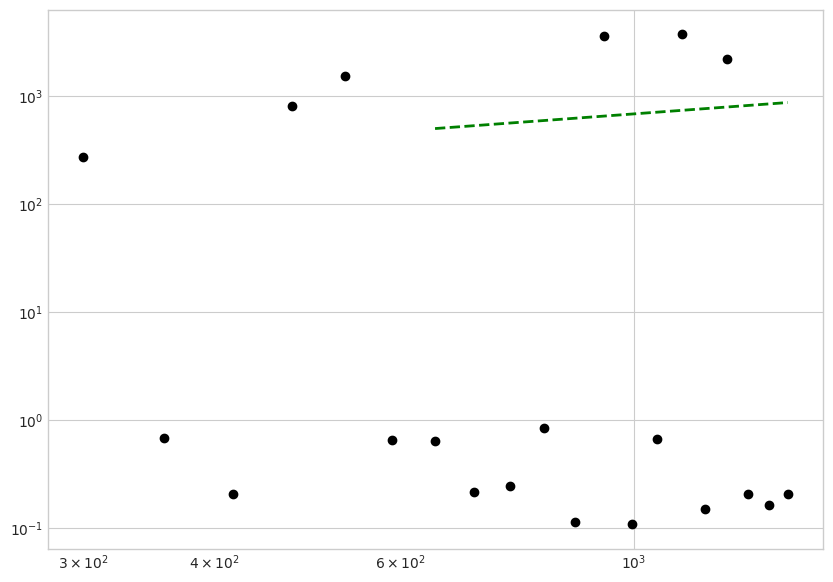

In [10]:
import os
import sys
sys.path.append("/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/scattering/simulation")

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
from tqdm import trange

from frb_scintillator_v8 import u, SimCfg, ScreenCfg, FRBScintillator

nu_ref = 1.0 * u.GHz
L_mw_ref = 2.0 * u.AU
L_host_ref = 10.0 * u.AU

base_cfg_dict = {
    "D_mw": 1.0 * u.kpc, "z_host": 0.05, "D_host_src": 4.0 * u.kpc,
    "nchan": 2048, "bw": 2.0 * u.MHz
}

sim_freqs = np.linspace(300, 1400, 20) * u.MHz
results = {"freqs": [], "nu_s_mw": [], "rp": []}

print("Running broadband analysis...")
for nu_sim in trange(len(sim_freqs), desc="Simulating frequencies"):
    nu0 = sim_freqs[nu_sim]

    # Robustly calculate scale factor by converting to base units first
    scale_factor = (nu0.to_value(u.Hz) / nu_ref.to_value(u.Hz))**-2

    L_mw_scaled = L_mw_ref * scale_factor
    L_host_scaled = L_host_ref * scale_factor

    cfg = SimCfg(
        **base_cfg_dict, nu0=nu0,
        mw=ScreenCfg(N=300, L=L_mw_scaled, rng_seed=int(nu0.to(u.Hz).value)),
        host=ScreenCfg(N=300, L=L_host_scaled, rng_seed=int(nu0.to(u.Hz).value)+1)
    )
    sim = FRBScintillator(cfg)

    spec = sim.simulate_time_integrated_spectrum()
    corr, lags = sim.acf(spec)
    nu_s_mw, _ = sim.fit_acf(corr, lags)

    if not np.isnan(nu_s_mw):
        results["freqs"].append(nu0.to(u.MHz).value)
        results["nu_s_mw"].append(nu_s_mw)
        results["rp"].append(sim.resolution_power())

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

freqs_mhz = np.array(results["freqs"])
nu_s_mhz = np.array(results["nu_s_mw"]) / 1e6
rps = np.array(results["rp"])

ax.loglog(freqs_mhz, nu_s_mhz, 'o', color='k', label="Simulation values")

def power_law(x, a, b): return a * x**b
unresolved_mask = rps < 1
if np.sum(unresolved_mask) > 1:
    popt, _ = curve_fit(power_law, freqs_mhz[unresolved_mask], nu_s_mhz[unresolved_mask])
    ax.plot(freqs_mhz[unresolved_mask], power_law(freqs_mhz[unresolved_mask], *popt),
            'g--', lw=2, label=f'Unresolved fit ($\\alpha \\approx {popt[1]:.2f}$)')
resolved_mask = rps > 3
if np.sum(resolved_mask) > 1:
    popt, _ = curve_fit(power_law, freqs_mhz[resolved_mask], nu_s_mhz[resolved_mask])
    ax.plot(freqs_mhz[resolved_mask], power_law(freqs_mhz[resolved_mask], *popt),
            'b--', lw=2, label=f'Highly Resolved fit ($\\alpha \\approx {popt[1]:.2f}$)')
if rps.size > 1:
    sorted_indices = np.argsort(rps)
    sorted_rps, sorted_freqs = rps[sorted_indices], freqs_mhz[sorted_indices]
    rp1_freq = np.interp(1.0, sorted_rps, sorted_freqs)
    rp3_freq = np.interp(3.0, sorted_rps, sorted_freqs)
    ax.axvline(rp1_freq, color='gray', ls='--', label='RP=1')
    ax.axvline(rp3_freq, color='gray', ls=':', label='RP=3')

ax.set(xlabel="Observing Frequency (MHz)", ylabel="Scintillation Bandwidth, $\\nu_{s,MW}$ (MHz)",
       title="Broadband Scintillation Analysis ($\nu_s \propto \\nu^\\alpha$)")
ax.legend()
ax.grid(True, which="both", ls="-", alpha=0.3)

plt.show()


Running broadband analysis...


Simulating frequencies:   0%|          | 0/20 [00:00<?, ?it/s]

nu0: 300.0 MHz
scale factor: 11.111111111111112


Simulating frequencies:   5%|▌         | 1/20 [00:01<00:35,  1.88s/it]

nu0: 357.89473684210526 MHz
scale factor: 7.807093425605537


Simulating frequencies:  10%|█         | 2/20 [00:02<00:23,  1.29s/it]

nu0: 415.7894736842105 MHz
scale factor: 5.784329434385515


Simulating frequencies:  15%|█▌        | 3/20 [00:03<00:18,  1.07s/it]

nu0: 473.6842105263158 MHz
scale factor: 4.45679012345679


Simulating frequencies:  20%|██        | 4/20 [00:04<00:15,  1.03it/s]

nu0: 531.578947368421 MHz
scale factor: 3.5388687383589845


Simulating frequencies:  25%|██▌       | 5/20 [00:05<00:14,  1.06it/s]

nu0: 589.4736842105262 MHz
scale factor: 2.8778698979591844


Simulating frequencies:  30%|███       | 6/20 [00:06<00:12,  1.12it/s]

nu0: 647.3684210526316 MHz
scale factor: 2.386145812677639


Simulating frequencies:  35%|███▌      | 7/20 [00:06<00:11,  1.16it/s]

nu0: 705.2631578947369 MHz
scale factor: 2.0104700378703493


Simulating frequencies:  40%|████      | 8/20 [00:07<00:10,  1.18it/s]

nu0: 763.1578947368421 MHz
scale factor: 1.7170035671819266


Simulating frequencies:  45%|████▌     | 9/20 [00:08<00:09,  1.16it/s]

nu0: 821.0526315789473 MHz
scale factor: 1.4833990795529262


Simulating frequencies:  50%|█████     | 10/20 [00:09<00:08,  1.19it/s]

nu0: 878.9473684210526 MHz
scale factor: 1.2944171537165192


Simulating frequencies:  55%|█████▌    | 11/20 [00:10<00:07,  1.21it/s]

nu0: 936.8421052631579 MHz
scale factor: 1.139376341371039


Simulating frequencies:  60%|██████    | 12/20 [00:10<00:06,  1.21it/s]

nu0: 994.7368421052631 MHz
scale factor: 1.0106100053190001


Simulating frequencies:  65%|██████▌   | 13/20 [00:11<00:05,  1.23it/s]

nu0: 1052.6315789473683 MHz
scale factor: 0.9025000000000001


Simulating frequencies:  70%|███████   | 14/20 [00:12<00:04,  1.24it/s]

nu0: 1110.5263157894738 MHz
scale factor: 0.8108533051818241


Simulating frequencies:  75%|███████▌  | 15/20 [00:13<00:04,  1.24it/s]

nu0: 1168.421052631579 MHz
scale factor: 0.7324892460027594


Simulating frequencies:  80%|████████  | 16/20 [00:14<00:03,  1.29it/s]

nu0: 1226.3157894736842 MHz
scale factor: 0.6649597524360368


Simulating frequencies:  85%|████████▌ | 17/20 [00:14<00:02,  1.27it/s]

nu0: 1284.2105263157894 MHz
scale factor: 0.6063558183284063


Simulating frequencies:  90%|█████████ | 18/20 [00:15<00:01,  1.27it/s]

nu0: 1342.1052631578946 MHz
scale factor: 0.5551710880430606


Simulating frequencies:  95%|█████████▌| 19/20 [00:16<00:00,  1.31it/s]

nu0: 1400.0 MHz
scale factor: 0.5102040816326531


Simulating frequencies: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

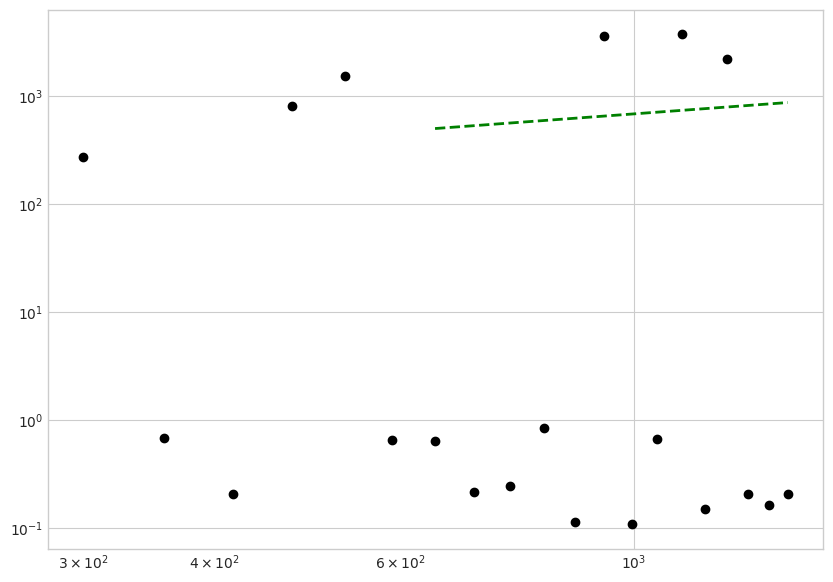

In [8]:
import os
import sys
sys.path.append("/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/scattering/simulation")

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
from tqdm import trange

from frb_scintillator_v8 import u, SimCfg, ScreenCfg, FRBScintillator

nu_ref = (1.0 * u.GHz).to(u.MHz)
L_mw_ref = (2.0 * u.AU).to(u.m)
L_host_ref = (10.0 * u.AU).to(u.m)

base_cfg_dict = {
    "D_mw": 1.0 * u.kpc, "z_host": 0.05, "D_host_src": 4.0 * u.kpc,
    "nchan": 2048, "bw": 2.0 * u.MHz
}

sim_freqs = np.linspace(300, 1400, 20) * u.MHz
results = {"freqs": [], "nu_s_mw": [], "rp": []}

print("Running broadband analysis...")
for nu_sim in trange(len(sim_freqs), desc="Simulating frequencies"):
    nu0 = sim_freqs[nu_sim]
    print(f'nu0: {nu0}')

    scale_factor = (nu0 / nu_ref).value**-2
    print(f'scale factor: {scale_factor}')
    L_mw_scaled, L_host_scaled = L_mw_ref * scale_factor, L_host_ref * scale_factor

    cfg = SimCfg(
        **base_cfg_dict, nu0=nu0,
        mw=ScreenCfg(N=300, L=L_mw_scaled, rng_seed=int(nu0.to(u.Hz).value)),
        host=ScreenCfg(N=300, L=L_host_scaled, rng_seed=int(nu0.to(u.Hz).value)+1)
    )
    sim = FRBScintillator(cfg)

    spec = sim.simulate_time_integrated_spectrum()
    corr, lags = sim.acf(spec)
    nu_s_mw, _ = sim.fit_acf(corr, lags)

    if not np.isnan(nu_s_mw):
        results["freqs"].append(nu0.to(u.MHz).value)
        results["nu_s_mw"].append(nu_s_mw)
        results["rp"].append(sim.resolution_power())

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

freqs_mhz = np.array(results["freqs"])
nu_s_mhz = np.array(results["nu_s_mw"]) / 1e6
rps = np.array(results["rp"])

ax.loglog(freqs_mhz, nu_s_mhz, 'o', color='k', label="Simulation values")

def power_law(x, a, b): return a * x**b
unresolved_mask = rps < 1
if np.sum(unresolved_mask) > 1:
    popt, _ = curve_fit(power_law, freqs_mhz[unresolved_mask], nu_s_mhz[unresolved_mask])
    ax.plot(freqs_mhz[unresolved_mask], power_law(freqs_mhz[unresolved_mask], *popt),
            'g--', lw=2, label=f'Unresolved fit ($\\alpha \\approx {popt[1]:.2f}$)')
resolved_mask = rps > 3
if np.sum(resolved_mask) > 1:
    popt, _ = curve_fit(power_law, freqs_mhz[resolved_mask], nu_s_mhz[resolved_mask])
    ax.plot(freqs_mhz[resolved_mask], power_law(freqs_mhz[resolved_mask], *popt),
            'b--', lw=2, label=f'Highly Resolved fit ($\\alpha \\approx {popt[1]:.2f}$)')
if rps.size > 1:
    sorted_indices = np.argsort(rps)
    sorted_rps, sorted_freqs = rps[sorted_indices], freqs_mhz[sorted_indices]
    rp1_freq = np.interp(1.0, sorted_rps, sorted_freqs)
    rp3_freq = np.interp(3.0, sorted_rps, sorted_freqs)
    ax.axvline(rp1_freq, color='gray', ls='--', label='RP=1')
    ax.axvline(rp3_freq, color='gray', ls=':', label='RP=3')

ax.set(xlabel="Observing Frequency (MHz)", ylabel="Scintillation Bandwidth, $\\nu_{s,MW}$ (MHz)",
       title="Broadband Scintillation Analysis ($\nu_s \propto \\nu^\\alpha$)")
ax.legend()
ax.grid(True, which="both", ls="-", alpha=0.3)

plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 253.9 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyne2001: filename=pyne2001-0.1.3-py3-none-any.whl size=93704 sha256=b9f1604dfcab204bc841c6b9aa880835c429b8a0326ddd88d6bcbabf39887bf2
  Stored in directory: /tmp/pip-ephem-wheel-cache-cmaaozzd/wheels/6b/a2/68/51e7e7b0a68b70e79a4f4479b9a81e95cc9a74daad2390aa53
Successfully built pyne2001
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 107.0 MB/s eta 0:00:00
